# 2次元場PDE - 基礎編 - 

In [1]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from scipy.signal import convolve2d
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D

## 拡散方程式

温度場の二次元拡散方程式を計算してみよう．
$$
    \partial_t \theta = k(\partial_{xx}+\partial_{yy}) \theta
$$

ラプラシアンを計算する時scipy.convolve2dが便利．"fill"で0境界，"wrap"オプション指定で周期境界，"symm"で勾配なし境界条件が作れる

In [2]:
# parameter
N = Nx = Ny = 25
Δ = Δx = Δy = 1./(N-1)
k = 0.01
D = (k/Δ**2)
A = np.array([[0.0,   D,0.0],
              [D  ,-4*D,  D],
              [0.0,   D,0.0],])
# init
x = np.linspace(0.0,1.0,N)
θ = np.zeros((N,N))
θ[0,N//2] = 50

t_span=[0.0,1.0]
t_eval=np.linspace(*t_span,3)

# ODEs
def ODEs(t,θ):
    θ = θ.reshape(N,N)
    dθ = convolve2d(θ,A,'same','wrap')
    return dθ.flatten()
#
sol = solve_ivp(ODEs,t_span,θ.reshape(-1),'RK45',t_eval)

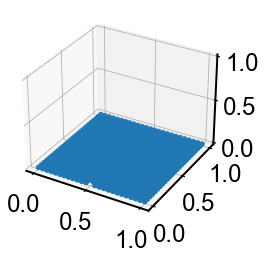

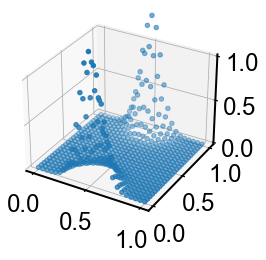

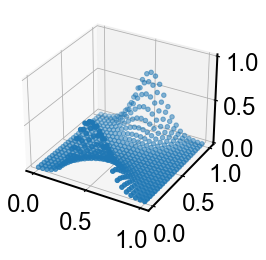

In [3]:
x = np.linspace(0.0,1.0,N)
x,y = np.meshgrid(x,x)
for θ in sol.y.T:
    θ = θ.reshape(N,N)
    fig,ax = plt.subplots(subplot_kw=dict(projection='3d',zlim=(0.0,1.0)))
    ax.scatter(x,y,θ)
    plt.show()

## Gray-Scott モデル

反応拡散方程式のインスタンスの一つである．
$$
    \partial_t u = D_u (\partial_{xx}+\partial_{yy})u + f(u,v) \\
    \partial_t v = D_v (\partial_{xx}+\partial_{yy})u + g(u,v) 
$$
のうち，関数$f,g$を
$$
    f(u,v) = - uv^2 + F(1-u) \\
    g(u,v) = + uv^2 - v(F+k) 
$$
と与えたもの．

説明は例えば，こちらの記事をどうぞ．
https://qiita.com/kaityo256/items/3c07252ab63591256835
コード中のパラメータも参考にさせていただきました．

In [4]:
# parameter
N = Nx = Ny = 40
Δ = Δx = Δy = 1.0
Du = (0.1 /Δ**2)
Dv = (0.05/Δ**2)
F = 0.04
k = 0.06075
A = np.array([[0.0 ,   Du, 0.0],
              [Du  ,-4*Du,  Du],
              [0.0 ,   Du, 0.0],])
B = np.array([[0.0 ,   Dv, 0.0],
              [Dv  ,-4*Dv,  Dv],
              [0.0 ,   Dv, 0.0],])

# init
x = np.linspace(0.0,1.0,N)
u = np.zeros((N,N))
v = np.zeros((N,N))
init = ()
h = N//2
u[h-3:h+3, h-3:h+3] = 0.9
v[h-1:h+1, h-1:h+1] = 0.7

t_span=[0.0,3000.0]
t_eval=np.linspace(*t_span,4)

# ODEs
def ODEs(t,U):
    u,v = U[:N*N].reshape(N,N),U[N*N:].reshape(N,N)
    du = convolve2d(u,A,'same','wrap') - u*v**2 + F*(1.0-u)
    dv = convolve2d(v,B,'same','wrap') + u*v**2 - v*(F + k)
    return np.hstack([du.flatten(),dv.flatten()])
#
sol = solve_ivp(ODEs,t_span,np.hstack([u.flatten(),v.flatten()]),'RK45',t_eval,rtol=1e-5)

とても面白い模様が見れる. FitzHugh–Nagumo方程式なども有名．

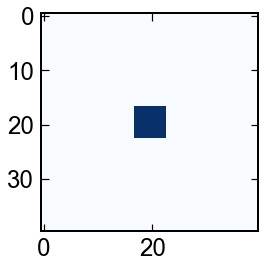

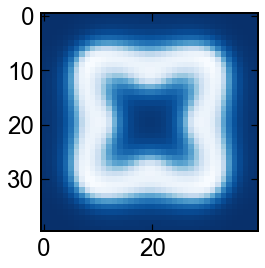

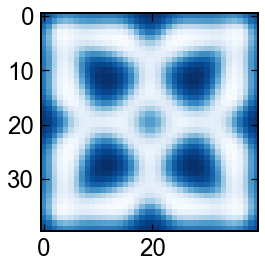

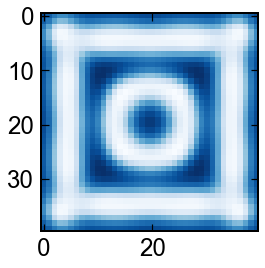

In [5]:
for u in sol.y.T[:,:N*N]:
    u = u.reshape(N,N)
    fig,ax = plt.subplots(figsize=(4,4))
    ax.imshow(u,cmap='Blues')
    plt.show()

## BZ反応

平衡点周りを振動しつつ，ゆっくりと平衡状態に近づく反応である．
モデルはいくつかあるが，今回は下の参考文献中のモデルを用いる．

$$
    \epsilon \partial_t x = x(1-x) -fz\frac{x-q}{x+q}+D_x (\partial_{xx}+\partial_{yy})x \\
    \partial_t z = x-z + D_z (\partial_{xx}+\partial_{yy}) z
$$

ここでは，
https://cattech-lab.com/science-tools/bz-reaction/
を参考にした．

In [6]:
# parameter
N = Nx = Ny = 50
Δ = Δx = Δy = 2.0/(N-1)
Dx = (1.0e-5/Δ**2)
Dz = (1.0e-5/Δ**2)
f = 0.95
ϵ = 0.08
q = 0.075
A = np.array([[0.0 ,   Dx, 0.0],
              [Dx  ,-4*Dx,  Dx],
              [0.0 ,   Dx, 0.0],])
B = np.array([[0.0 ,   Dz, 0.0],
              [Dz  ,-4*Dz,  Dz],
              [0.0 ,   Dz, 0.0],])

# init
x = 0.1*np.ones((N,N))
z = 0.1*np.ones((N,N))
z[N//2-6,N//2] *= 1.01
z[N//2-10,N//2+15] *= 1.01
z[N//2+14,N//2-5] *= 1.01

t_span=[0.0,500.0]
t_eval=np.linspace(*t_span,5)

# ODEs
def ODEs(t,X):
    x,z = X[:N*N].reshape(N,N),X[N*N:].reshape(N,N)
    dx = (x*(1.-x) - f*z*(x-q)/(x+q) + convolve2d(x,A,'same','wrap') )/ϵ
    dz = x-z + convolve2d(z,B,'same','wrap') 
    return np.hstack([dx.flatten(),dz.flatten()])
#
sol = solve_ivp(ODEs,t_span,np.hstack([x.flatten(),z.flatten()]),'RK23',t_eval,rtol=1e-8,atol=1e-6)

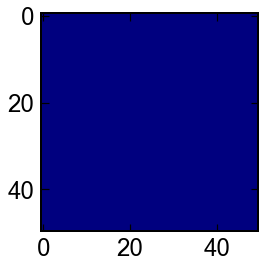

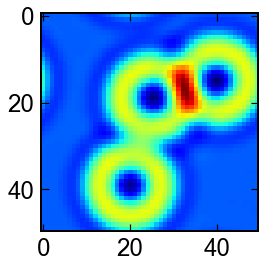

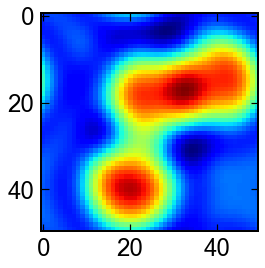

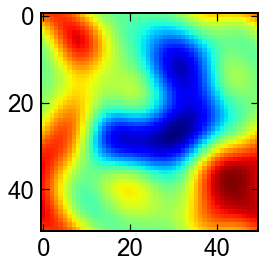

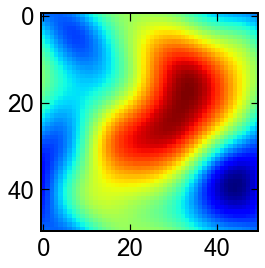

In [7]:
for u in sol.y.T[:,:N*N]:
    u = u.reshape(N,N)
    fig,ax = plt.subplots(figsize=(4,4))
    ax.imshow(u,cmap='jet')
    plt.show()